# Global Food Security Index Prediction

In [102]:
import sys
!{sys.executable} -m pip install scipy


You should consider upgrading via the 'c:\Python39\python.exe -m pip install --upgrade pip' command.


In [103]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Problem Statement

## Background Description

Tackling food hunger issues is the second goal of the United Nations’ Sustainable Development Goals (SDG). Despite continued efforts in tackling this issue, global food security has been decreasing over the past few years. In 2020, between 720 million and 811 million persons worldwide were suffering from hunger, roughly 161 million more than in 2019. In 2022, affordability decreased sharply due to rapid rises in food costs, decreasing trade freedom and less funding for food safety nets. This has led to a wider difference between the top and bottom-ranked countries in the Global Food Security Index (GFSI) since 2019, highlighting the inequality between countries in food security. Thus, we have opted to solve the problem of food insecurity. 

## User Persona

Under a limited annual budget, the United Nations (UN) has to decide which countries best require support for food security. However, the food security index is only done once a year and does not consider all countries in the world. Predicting the GFSI by entering a country’s features would be useful to prioritize the fund allocation to countries that need the most help. The UN Security Council may use our model by training data from a range of years, which would yield an equation/model to predict the GFSI of a country. 

## Defining Problem Statement

To create the problem statement, we first discussed ways to measure the food security of a country. We decided to use the Global Food Security Index (GFSI), a well-rounded index that considers affordability, availability, quality and safety as well as sustainability and adaptation. We then brainstormed various features which would affect the food security of a country: GDP per capita, Education Index, Corruption Perception Index, Percentage of Population Vaccinated, Political Stability, Crop Production Index, Export of Goods, Percentage of Food Produce Exported, Poverty Rate, Road Density and Food Security Index (Target).

After considering our user persona, we arrive at our final problem statement:
<br>
<br>
<strong>How might we create a model to predict a country’s Global Food Security Index (GFSI) by entering a country’s features, thus allowing UN Security Council members to weigh the importance of assisting this country?</strong>


# Data

## Data Sources

| Features | Link | 
| --- | --- |
| GDP per capita | https://www.kaggle.com/datasets/zgrcemta/world-gdpgdp-gdp-per-capita-and-annual-growths?search=gdp |
| Education index | https://rankedex.com/society-rankings/education-index | 
| Corruption perception index 2018 | https://www.kaggle.com/datasets/transparencyint/corruption-index | 
| % of population vaccinated | https://ourworldindata.org/covid-vaccinations |
| Political Stability | https://www.theglobaleconomy.com/rankings/wb_political_stability/ |
| Crop Production Index | https://www.theglobaleconomy.com/rankings/crop_production_index/ |
| % of food produce exported | https://www.fao.org/faostat/en/#data/QCL |
| Poverty rate | https://worldpopulationreview.com/country-rankings/poverty-rate-by-country |
| Road density | https://en.wikipedia.org/wiki/List_of_countries_by_road_network_size |

| Target | Link |
| --- | --- |
| Global Food Security Index (GFSI) | https://impact.economist.com/sustainability/project/food-security-index/ |

## Why we use the data?

| Features | Reasoning | 
| --- | --- |
| GDP per capita | bcs |
| Education index | bcs | 
| Corruption perception index 2018 | bcs | 
| % of population vaccinated | bcs |
| Political Stability | bcs |
| Crop Production Index | bcs |
| % of food produce exported | bcs |
| Poverty rate | bcs |
| Road density | bcs |

| Target | Reasoning |
| --- | --- |
| Global Food Security Index (GFSI) | Most objective measure of food security |

# In-Cohort Functions

## Helper Functions

Includes normalizeation, basic matrix calculations, as well as dataframe preparations

In [104]:
# Helper Functions

def normalize_z(df):
    return (df-df.mean(axis=0))/(df.std(axis=0))
    pass

def get_features_targets(df, feature_names, target_names):
    df_feature = df[feature_names]
    df_target = df[target_names]
    return df_feature, df_target

def prepare_feature(df_feature):
    cols = len(df_feature.columns)
    feature = df_feature.to_numpy().reshape(-1, cols)
    # print(feature, type(feature), feature.shape)
    X = np.concatenate((np.ones((feature.shape[0],1)), feature), axis=1)
    return X

def prepare_target(df_target):
    cols = len(df_target.columns)
    target = df_target.to_numpy().reshape(-1,cols)
    return target

def predict(df_feature, beta):
    arr_feature_norm = prepare_feature(normalize_z(df_feature))
    return calc_linear(arr_feature_norm, beta)

def calc_linear(X, beta):
    return np.matmul(X,beta)

## Metrics Functions

In [105]:
def r2_score(y, ypred):
    y_bar = (1/len(y))*(np.sum(y,axis=0))
    SS_tot = np.sum((y - y_bar)**2, axis=0)
    SS_res = np.sum((y - ypred)**2, axis=0)
    return (1 - (SS_res/SS_tot))

def mean_squared_error(target, pred):
    return (1/len(target)) * np.sum((target - pred)**2, axis=0)

def root_mean_squared_error(target, pred):
    return mean_squared_error(target, pred)**0.5

def mean_absolute_error (target, pred):
    return (1/len(target)) * np.sum(np.absolute(target - pred), axis=0)

### Adjusted R Squared

Adjusted r-squared is used when there is too many features (more than 5). Since we have a lot of features, we are also using this metric too evaluate our model.
<br><br>
A negative value of this metric would mean that the model is not accurate enough or we have too many irrelevant features inside.

In [106]:
# This is not in cohort, but also a metric function
def adj_r2_score(y, ypred, N, p):
    # N: total sample size, no of rows
    # p: no of independent variable, no of cols of feature

    num1 = 1 - r2_score(y, ypred)
    num2 = N - 1
    den = N - p -1

    calculated = num1*num2/den

    return 1 - calculated

## Machine Learning Functions

Includes cost computations and gradient descent.

In [107]:
#ML Functions

def compute_cost(X, y, beta):
    ### Params
    # X: np.array
    # y: np.array
    # beta: np.array

    ### This function is the value of squared error plus a few modifs to make calculations easier
    J = 0
    y_hat = calc_linear(X, beta)
    err = y_hat - y 
    m = X.shape[0]
    err_sq = np.matmul(err.T, err)
    
    J = (1/(2*m)) * err_sq
    return J[0][0]

def gradient_descent(X, y, beta, alpha, num_iters):
    ### Params
    # X: np.array
    # y: np.array
    # beta: np.array
    # alpha: float
    # num_iters: int

    J_storage = []
    m = X.shape[0]
    
    for i in range(num_iters):
        # print(i)
        # cost computation and append
        J = compute_cost(X, y, beta)
        J_storage.append(J)
        
        # suku pertama
        a = (alpha/m) * X.T
        # suku kedua
        pred_y = calc_linear(X, beta)
        b = pred_y - y
        
        beta = beta - np.matmul(a,b)
        
    return beta, J_storage

# Splitting Data for Training, Validation, and Testing

The purpose for this split is to not bias the model on the testing dataset. The procedure will be to train data, test data on validation set, fine-tune the model, and re-test it on the validation set for a few iterations.

After doing everything, we select the best model and see how it performs on the test set, and give report based on that.

In [108]:
def split_data_new(df_feature, df_target, random_state=None, test_size=0.15):
    # print(len(df_feature) == len(df_target))
    
    test_validation_len = int((test_size * 2) * len(df_feature))
    test_len = int(test_size * len(df_feature))
    # print(test_len)
    # train_len = len(df_feature) - test_len
    # print(train_len)
    
    np.random.seed(random_state)
    row_test_validation = np.random.choice(len(df_feature), test_validation_len, replace=False)
    # actual used one
    row_test = np.random.choice(row_test_validation, test_len, replace=False)
    row_validation = np.array([i for i in row_test_validation if i not in row_test])
    row_train = np.array([i for i in range(len(df_feature)) if i not in row_test_validation])
    
    # print(row_test, row_train)
    # print(0 in row_test)
    
    df_feature_train = df_feature.iloc[[i for i in row_train]]
    df_feature_test = df_feature.iloc[[i for i in row_test]]
    df_feature_validation = df_feature.iloc[[i for i in row_validation]]
    
    df_target_train = df_target.iloc[[i for i in row_train]]
    df_target_test = df_target.iloc[[i for i in row_test]]
    df_target_validation = df_target.iloc[[i for i in row_validation]]
    
    return df_feature_train, df_feature_test, df_feature_validation, df_target_train, df_target_test, df_target_validation

## Test for Splitting the Data

This section is only used for internal testing, to make sure the function works.

In [109]:
dataF = pd.read_csv("MainData.csv")
df_features, df_target = get_features_targets(dataF, ["GDP Capita"], ["FOOD GFSI"])

df_features_train, df_features_test, df_features_validation, df_target_train, df_target_test, df_target_validation = split_data_new(df_features, df_target, random_state=100, test_size=0.15)

display(df_features_train.head(6), df_features_train.shape)
display(df_features_validation, df_features_validation.shape)
display(df_features_test, df_features_test.shape)

,GDP Capita
0,49964.50
1,79068.97
2,82267.81
3,41572.49
4,53018.63
6,54589.06


(80, 1)

,GDP Capita
21,57180.78
43,9686.98
29,65907.95
93,503.32
90,1241.83
78,4059.21
85,1458.07
62,3893.86
32,18703.86
107,238.78


(17, 1)

,GDP Capita
75,2014.58
104,740.75
41,11380.08
51,8050.64
36,6957.79
28,9446.70
35,21087.85
64,6729.58
69,5782.78
72,1597.07


(16, 1)

# Preparing Dataframe

Here, we separate the feature and target dataframe, as well as do a train-test-validation split. We clean the data by removing the NaN values, as well as dropping the "Country" column which is useless for the process.

In [110]:
# Read the CSV file
df = pd.read_csv("MainData.csv")
print(df.columns)
display(df.head(), df.shape)

# drop NaN values
df = df.dropna()
display(df.head(), df.shape)

# determine feature columns
feature_columns = [column for column in df.columns]
feature_columns.remove("Country")
feature_columns.remove("FOOD GFSI")

# determine target columns
target_column = ["FOOD GFSI"]

# prepare feature and target df
df_features, df_target = get_features_targets(df, feature_columns, target_column)
display(df_features.head())

# split for train test validation
df_features_train, df_features_test, df_features_validation, df_target_train, df_target_test, df_target_validation = split_data_new(df_features, df_target, random_state=90, test_size=0.15)

display(df_features_train.head(), df_features_train.shape)
display(df_features_test.head(), df_features_test.shape)
display(df_features_validation.head(), df_features_validation.shape)

Index(['Country', 'FOOD GFSI', 'GDP Capita', 'Education Index', 'Corruption',
       'Vaccination Rate (%)', 'Political Stability', 'Crop Production',
       'Percentage of Export', 'Poverty Rate', 'Road density'],
      dtype='object')


,Country,FOOD GFSI,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
0,Finland,825,49964.50,0.905,89.0,78.42,98.0,106.4,16.852496,12.2,135.0
1,Ireland,817,79068.97,0.918,73.0,80.72,86.0,88.1,46.479800,13.1,142.0
2,Norway,805,82267.81,0.915,85.0,74.61,11.0,102.2,15.494013,12.7,NaN
3,France,802,41572.49,0.840,69.0,78.30,37.0,98.9,42.414468,13.6,191.0
4,Netherlands,801,53018.63,0.906,83.0,68.08,92.0,100.7,NaN,13.6,332.0


(113, 11)

,Country,FOOD GFSI,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
0,Finland,825,49964.50,0.905,89.0,78.42,98.0,106.4,16.852496,12.2,135.0
1,Ireland,817,79068.97,0.918,73.0,80.72,86.0,88.1,46.479800,13.1,142.0
3,France,802,41572.49,0.840,69.0,78.30,37.0,98.9,42.414468,13.6,191.0
5,Japan,795,39808.17,0.848,72.0,83.07,103.0,96.4,1.259819,15.7,93.0
6,Sweden,791,54589.06,0.904,88.0,72.31,103.0,105.2,27.315509,17.1,127.0


(85, 11)

,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
0,49964.50,0.905,89.0,78.42,98.0,106.4,16.852496,12.2,135.0
1,79068.97,0.918,73.0,80.72,86.0,88.1,46.479800,13.1,142.0
3,41572.49,0.840,69.0,78.30,37.0,98.9,42.414468,13.6,191.0
5,39808.17,0.848,72.0,83.07,103.0,96.4,1.259819,15.7,93.0
6,54589.06,0.904,88.0,72.31,103.0,105.2,27.315509,17.1,127.0


,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
0,49964.50,0.905,89.0,78.42,98.0,106.4,16.852496,12.2,135.0
1,79068.97,0.918,73.0,80.72,86.0,88.1,46.479800,13.1,142.0
3,41572.49,0.840,69.0,78.30,37.0,98.9,42.414468,13.6,191.0
6,54589.06,0.904,88.0,72.31,103.0,105.2,27.315509,17.1,127.0
8,43646.95,0.914,81.0,75.19,54.0,99.7,18.785180,18.6,175.0


(60, 9)

,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
20,15468.48,0.866,62.0,56.68,51.0,92.2,27.254728,15.4,136.0
30,19747.34,0.838,44.0,73.58,15.0,75.4,41.147680,17.9,89.0
58,7005.10,0.708,45.0,32.56,-71.0,104.7,17.078584,55.5,61.0
90,1241.83,0.471,36.0,20.17,-3.0,109.4,5.728364,38.5,14.0
63,7296.88,0.661,35.0,74.60,-55.0,99.8,18.795892,9.9,137.0


(12, 9)

,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
25,9905.34,0.644,40.0,89.22,-48.0,107.9,1.529869,0.6,54.0
86,7503.88,0.659,60.0,52.40,98.0,119.5,23.897393,19.3,5.0
44,12398.98,0.762,48.0,41.28,53.0,123.8,45.214157,23.8,36.0
61,3680.89,0.659,41.0,51.67,-7.0,108.0,5.393898,15.2,12.0
67,4142.02,0.664,34.0,14.43,-88.0,121.0,2.247170,5.5,4.0


(13, 9)

# First Iteration: No Modification

We use the data as it is, without extra cleaning and transformation. We directly apply normalisation for the linear regression directly.

In [111]:
# Normalize the train features using z normalization
df_features_train_z = normalize_z(df_features_train)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_z)
target = prepare_target(df_target_train)

iterations = 1500
alpha = 0.01
beta1 = np.zeros((df_features_train_z.shape[1] + 1,1)) # beta for first iteration

# Call the gradient_descent function
beta1, J_storage = gradient_descent(X, target, beta1, alpha, iterations)
print(beta1)

# call the predict() method
pred = predict(df_features_validation, beta1)
print(pred)

[[630.04982128]
 [ 24.00030123]
 [ 52.41133827]
 [ 14.64900029]
 [ 29.16136684]
 [ -4.98461486]
 [  9.84335708]
 [ 22.405263  ]
 [-12.75953492]
 [ -7.11585862]]
[[649.61972296]
 [646.89300622]
 [696.07028264]
 [605.44723608]
 [587.94157247]
 [892.77360894]
 [693.33629948]
 [725.42629178]
 [505.67717621]
 [561.41679631]
 [390.66219284]
 [638.32631784]
 [597.05717289]]


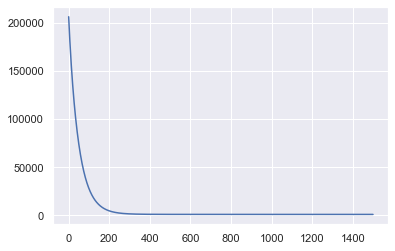

In [112]:
# J_storage plot shows that the error function decreases to close to 0
plt.plot(J_storage)

GDP Capita


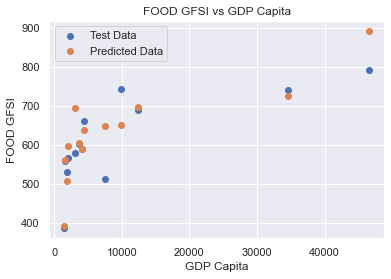

Education Index


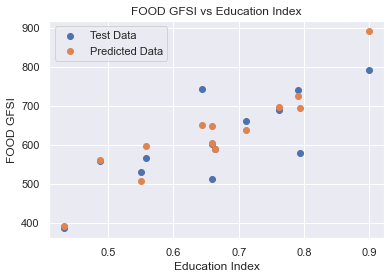

Corruption


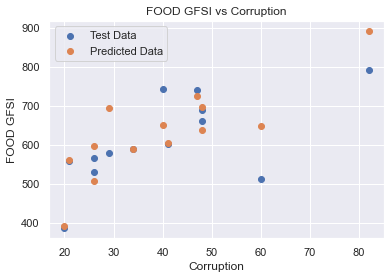

Vaccination Rate (%)


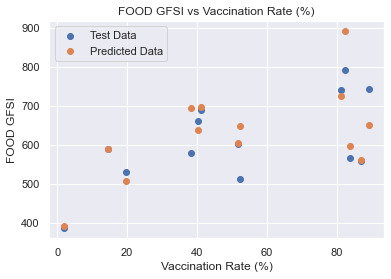

Political Stability


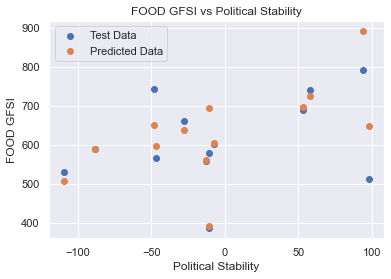

Crop Production


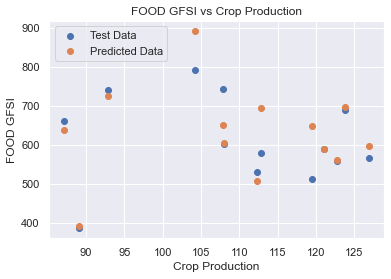

Percentage of Export


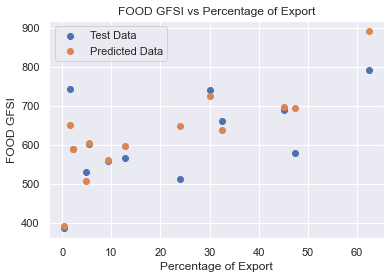

Poverty Rate


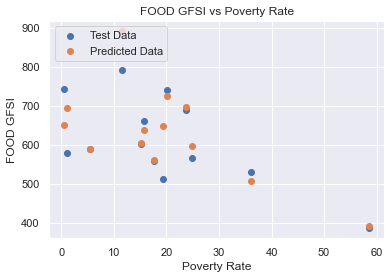

Road density


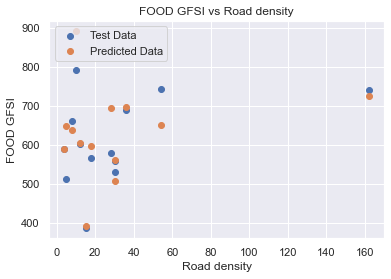

In [113]:
for column in feature_columns:
    print(column)
    x = df_features_validation[column]
    y_test = df_target_validation["FOOD GFSI"]
    y_pred = pred
    plt.scatter(x, y_test, label="Test Data")
    plt.scatter(x, y_pred, label="Predicted Data")
    plt.xlabel(f"{column}")
    plt.ylabel("FOOD GFSI")
    plt.title(f"FOOD GFSI vs {column}")
    plt.legend(loc="upper left")
    plt.show()

In [114]:
target = prepare_target(df_target_validation)
r2 = r2_score(target, pred)
print(f"r^2 = {r2[0]}")

target = prepare_target(df_target_validation)
adj_r2 = adj_r2_score(target, pred, df_features_validation.shape[0], df_features_validation.shape[1])
print(f"adj r^2 = {adj_r2[0]}")

target = prepare_target(df_target_validation)
mse = mean_squared_error(target, pred)
print(f"mse = {mse[0]}")

target = prepare_target(df_target_validation)
mae = mean_absolute_error(target, pred)
print(f"mae = {mae[0]}")

r^2 = 0.6447893450070279
adj r^2 = -0.42084261997188843
mse = 4068.0363643587443
mae = 43.051193394530785


As can be seen here, the adjusted r-squared is negative, meaning that we need meaning that we might need to increase the accuracy of the relationships or decrease irrelevant features.

In [115]:
print(beta1)

[[630.04982128]
 [ 24.00030123]
 [ 52.41133827]
 [ 14.64900029]
 [ 29.16136684]
 [ -4.98461486]
 [  9.84335708]
 [ 22.405263  ]
 [-12.75953492]
 [ -7.11585862]]


# Second Iteration: Linearizing the Data

To make the model better, firstly we want to transform the data so it can have a better linear relationship with the target column.
<br>
<br>
First we try to plot each of the data to see the shape that the data points take wrt target column.

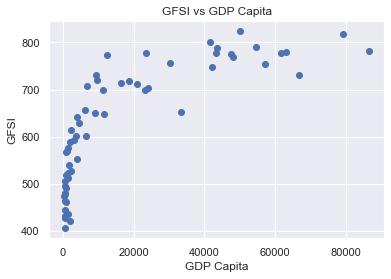

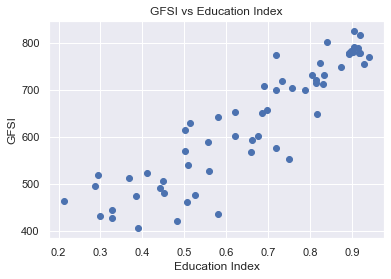

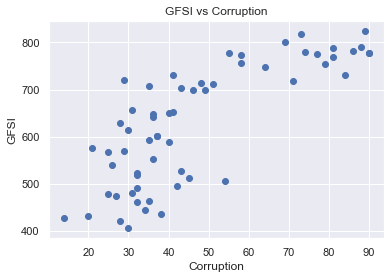

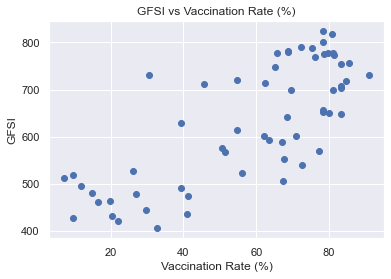

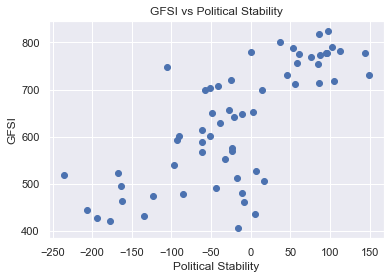

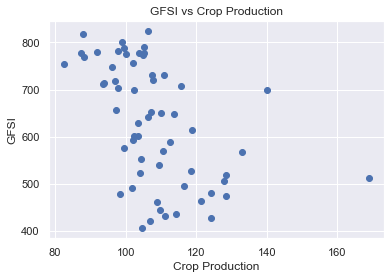

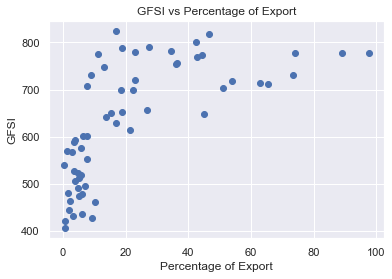

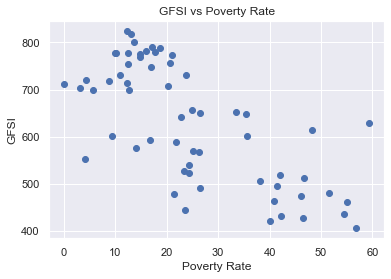

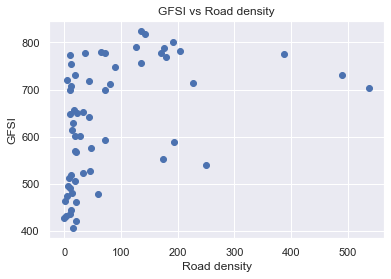

In [116]:
sns.set()

# plot all features against GFSI to see how important each are
for column in feature_columns:
    plt.scatter(df_features_train[column], df_target_train["FOOD GFSI"])
    plt.title(f"GFSI vs {column}")
    plt.xlabel(f"{column}")
    plt.ylabel("GFSI")
    plt.show()

## Data Transformation

### Mathematical Functions to Transform

Based on the shapes of the data, we decided that it might fit 5 transformations below. Below are the listed functions and what it does to the data.

| Functions | What it does? |
| --- | --- |
| ```natural_log(x)``` | shift all values of ```x``` to be greater than ```0```, then apply natural log to every data point |
| ```power_2(x)``` | shift all values of ```x``` to be greater than or equal to ```0```, then apply power of ```2``` to every data point |
| ```power_3(x)``` | shift all values of ```x``` to be greater than or equal to ```0```, then apply power of ```3``` to every data point |
| ```sqrt_2(x)``` | shift all values of ```x``` to be greater than or equal to ```0```, then apply power of ```1/2``` to every data point |
| ```sqrt_3(x)``` | shift all values of ```x``` to be greater than or equal to ```0```, then apply power of ```1/3``` to every data point |

In [117]:
def natural_log(x):
    # returns transformed value based on natural log transformation
    return np.log(x + np.absolute(np.min(x)) + 0.01)

def power_2(x):
    return np.power(x + np.absolute(np.min(x)), 2)

def power_3(x):
    return np.power(x + np.absolute(np.min(x)), 3)

def sqrt_2(x):
    return np.power(x + np.absolute(np.min(x)), 1/2)

def sqrt_3(x):
    return np.power(x + np.absolute(np.min(x)), 1/3)

### Define Functions to Plot GSFI vs All Transformed Data and Find Correlation Coefficient For Each

In [118]:
def correlation_coef(x, y):
    cov_matrix = np.cov(np.array(x), np.array(y))
    # print(cov_matrix)

    r = cov_matrix[0][1]/np.sqrt(cov_matrix[0][0] * cov_matrix[1][1])
    return r

def plot_scatter(x, y, xlabel, ylabel, trans_label=""):
    r_sq = correlation_coef(x, y)**2
    plt.scatter(x, y)
    plt.xlabel(f"{xlabel} Transformed")
    plt.ylabel(f"{ylabel}")
    plt.title(f"{ylabel} vs {xlabel} {trans_label}")
    plt.text(max(x),min(y),f"r^2 = {r_sq}")
    plt.show()
    return r_sq, trans_label

def plot_all_transformations(x, y, xlabel, ylabel):
    # Linear
    r_linear = plot_scatter(x, y, xlabel, ylabel, "Linear")
    # natural log
    r_naturalLog = plot_scatter(natural_log(x), y, xlabel, ylabel, "Natural Log")
    # Power of two
    r_powerOf2 = plot_scatter(power_2(x), y, xlabel, ylabel, "Power of Two")
    # Power of three
    r_powerOf3 = plot_scatter(power_3(x), y, xlabel, ylabel, "Power of Three")
    # Power of 1/2
    r_sqrt2 = plot_scatter(sqrt_2(x), y, xlabel, ylabel, "Power of 1/2")
    # Power of 1/3
    r_sqrt3 = plot_scatter(sqrt_3(x), y, xlabel, ylabel, "Power of 1/3")
    all_r_sq = [r_linear, r_naturalLog, r_powerOf2, r_powerOf3, r_sqrt2, r_sqrt3]
    
    max_r_sq = max([i[0] for i in all_r_sq])
    max_idx = [i[0] for i in all_r_sq].index(max_r_sq)
    max_trans_label = all_r_sq[max_idx][1]
    
    return max_r_sq, max_trans_label

### Plot All the Food GFSI wrt each Column Transformations

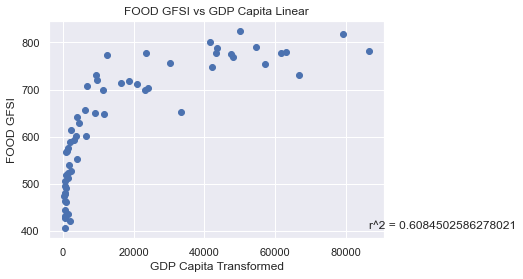

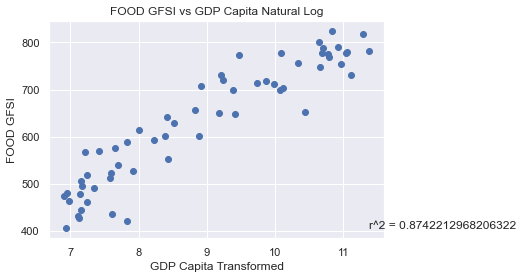

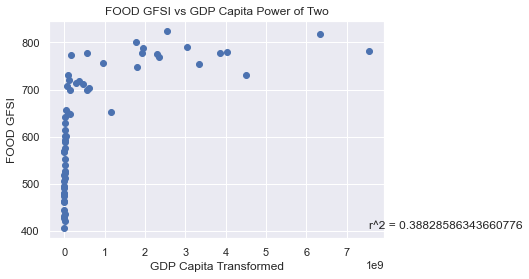

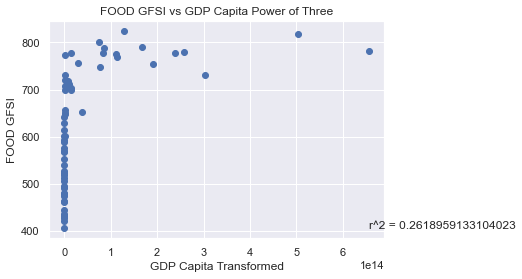

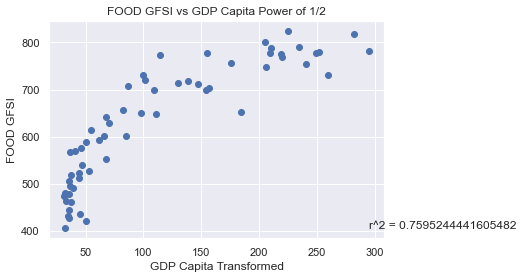

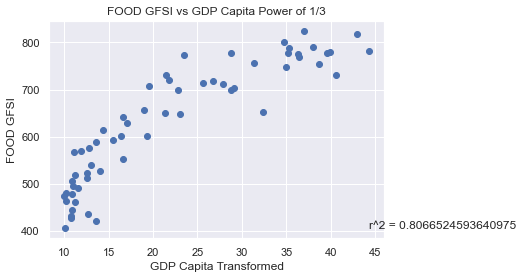

for column = GDP Capita, max_r^2 = 0.8742212968206322, transformation = Natural Log


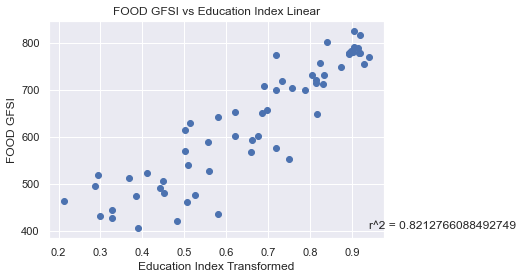

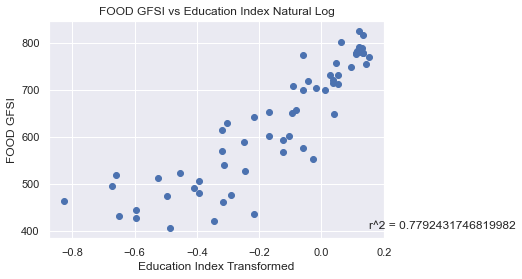

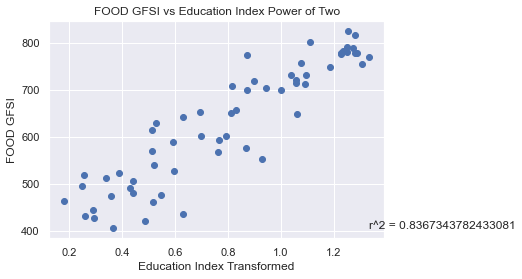

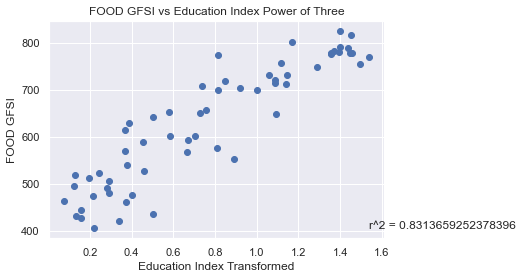

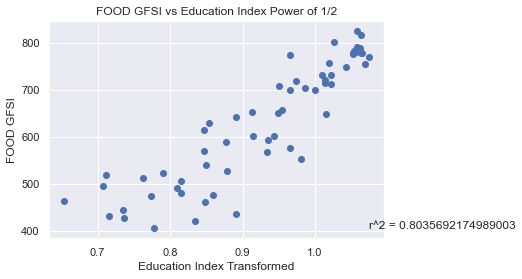

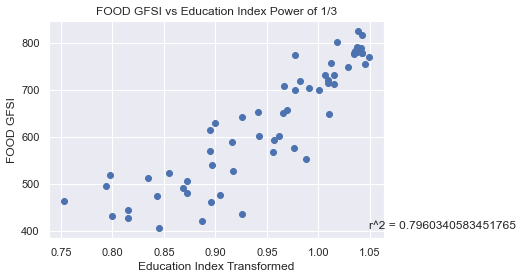

for column = Education Index, max_r^2 = 0.8367343782433081, transformation = Power of Two


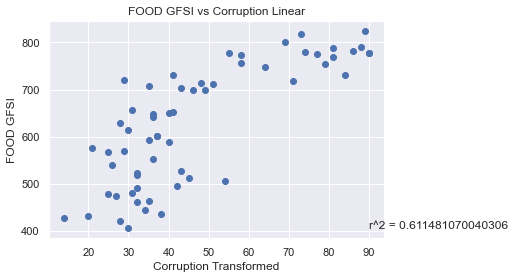

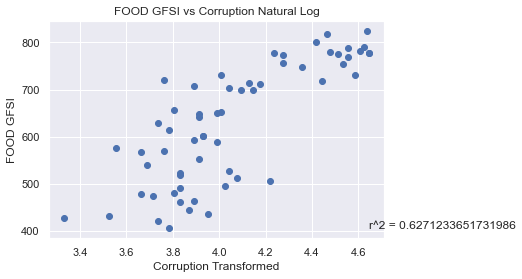

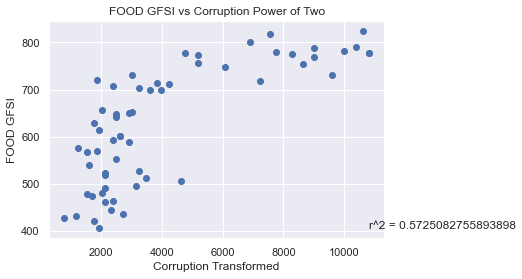

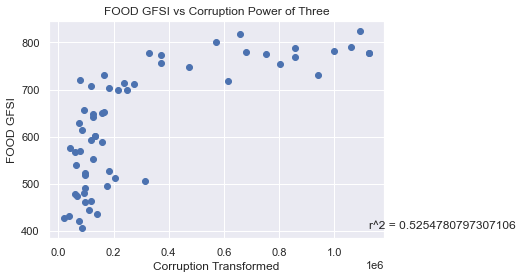

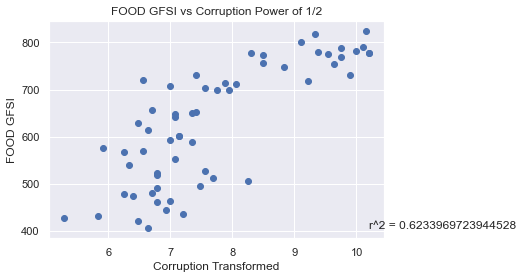

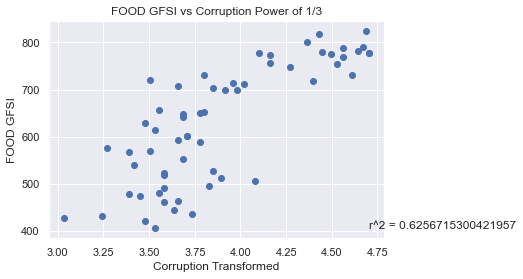

for column = Corruption, max_r^2 = 0.6271233651731986, transformation = Natural Log


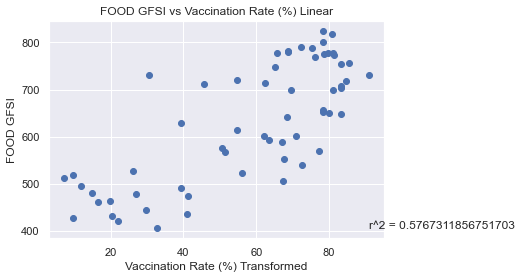

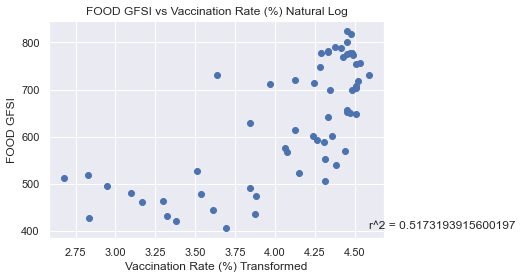

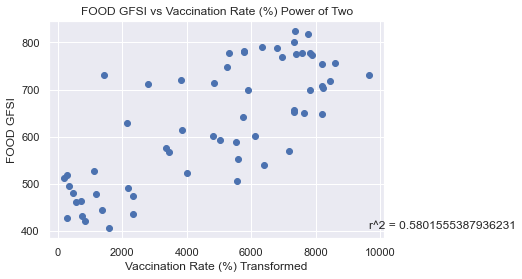

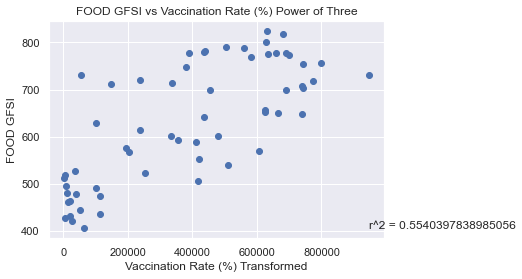

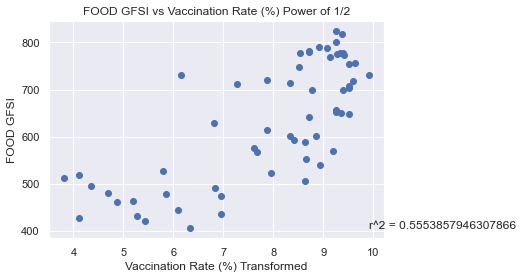

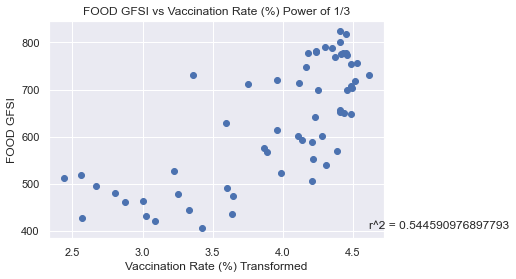

for column = Vaccination Rate (%), max_r^2 = 0.5801555387936231, transformation = Power of Two


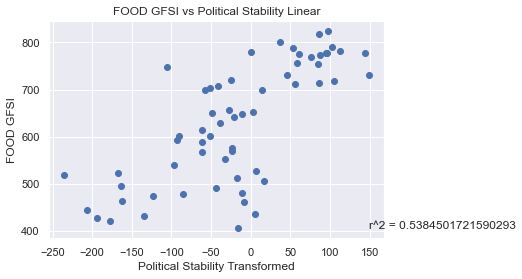

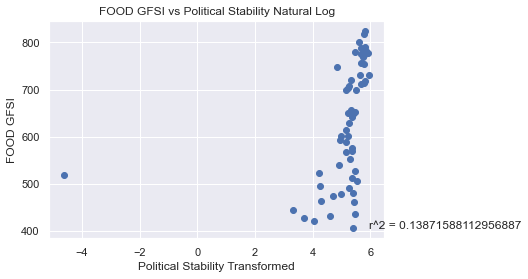

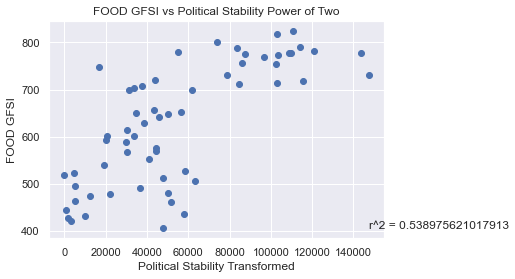

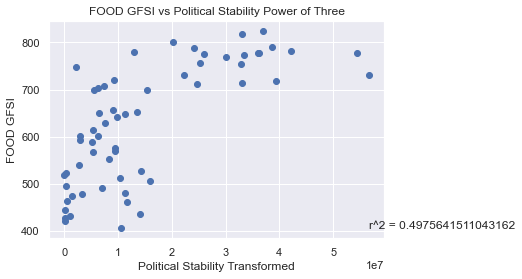

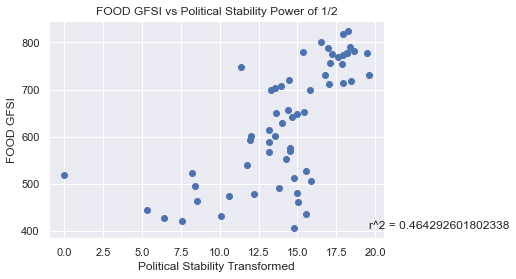

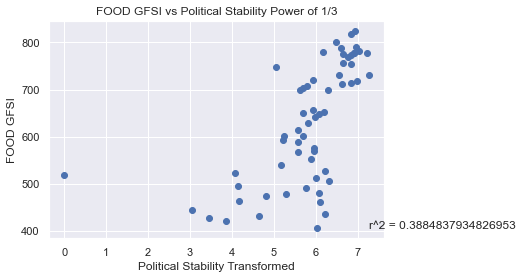

for column = Political Stability, max_r^2 = 0.538975621017913, transformation = Power of Two


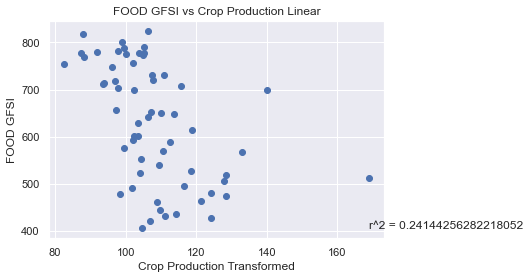

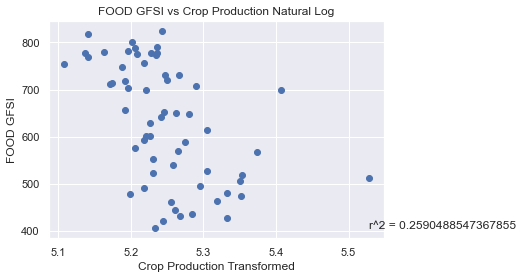

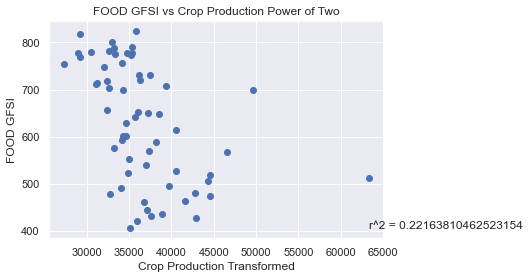

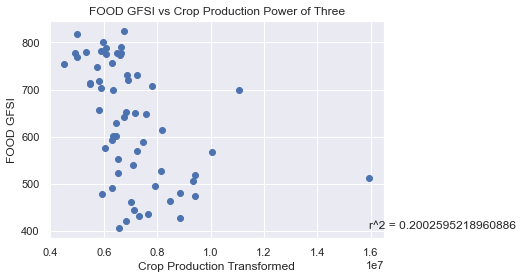

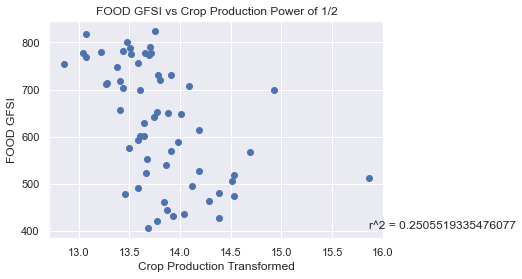

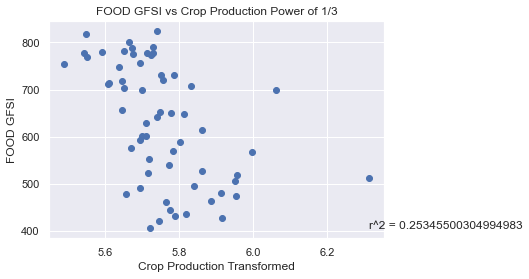

for column = Crop Production, max_r^2 = 0.2590488547367855, transformation = Natural Log


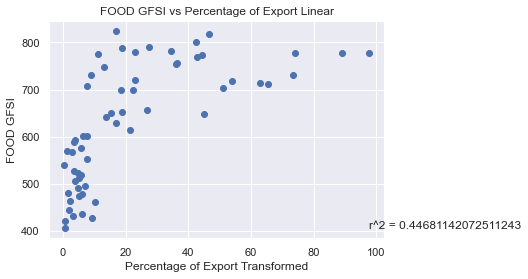

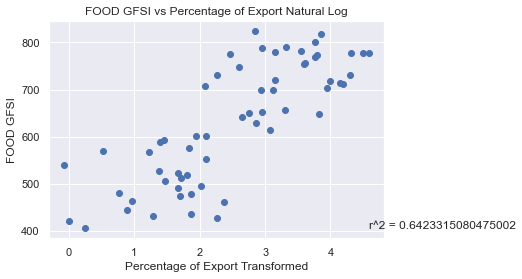

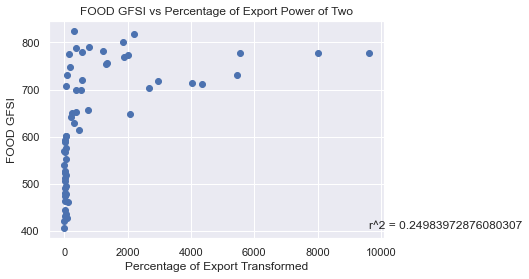

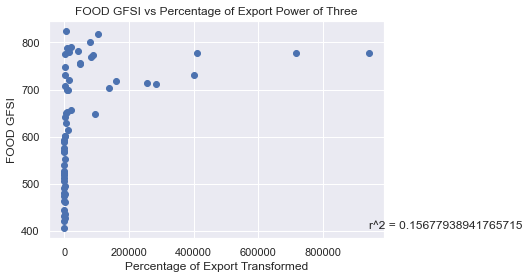

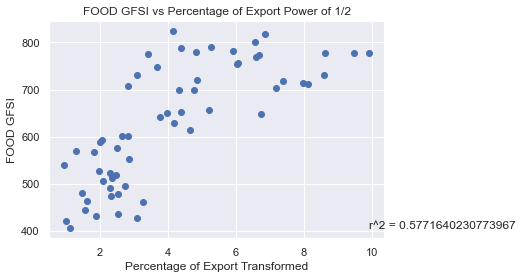

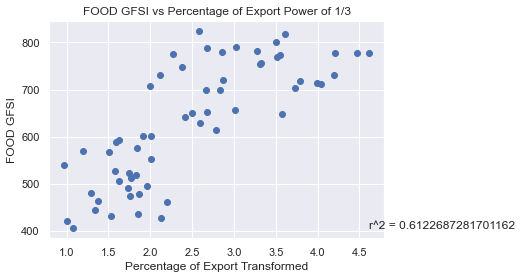

for column = Percentage of Export, max_r^2 = 0.6423315080475002, transformation = Natural Log


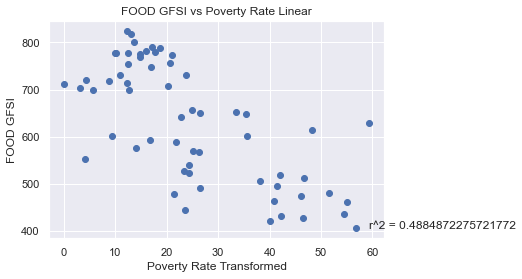

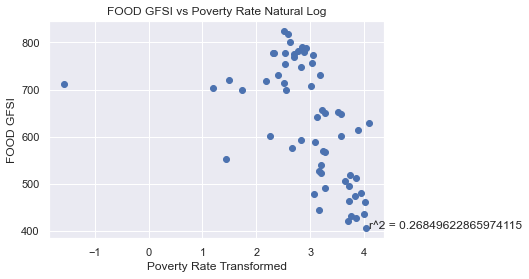

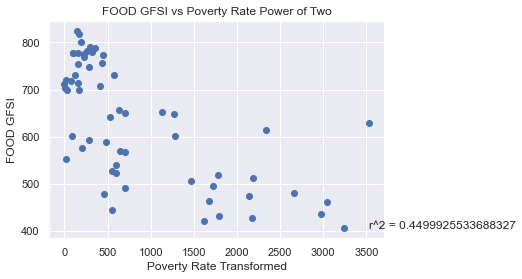

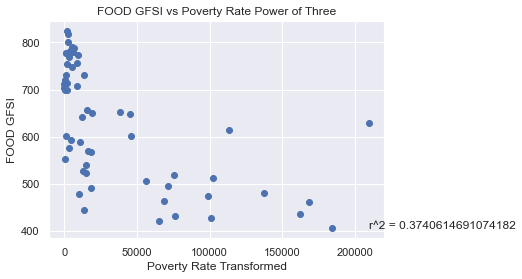

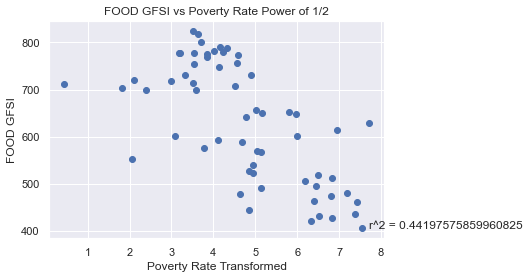

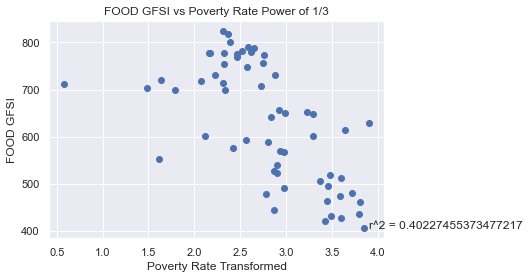

for column = Poverty Rate, max_r^2 = 0.4884872275721772, transformation = Linear


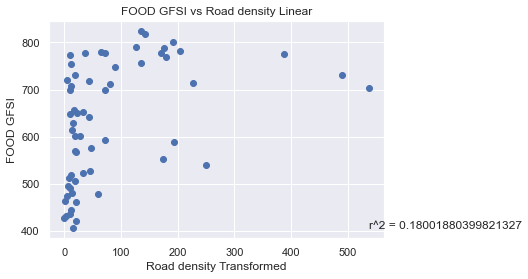

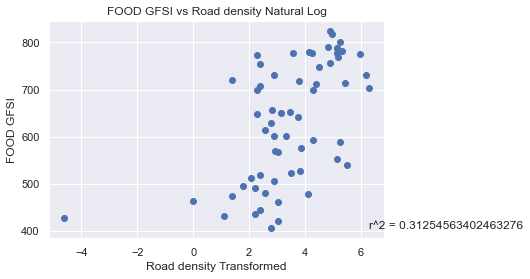

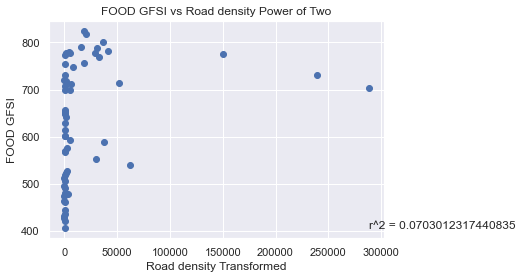

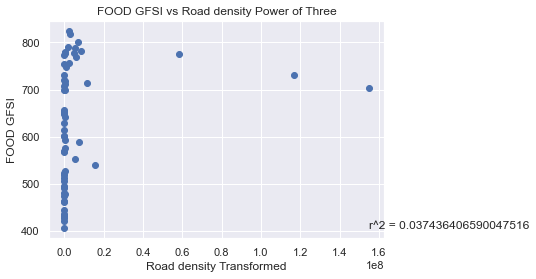

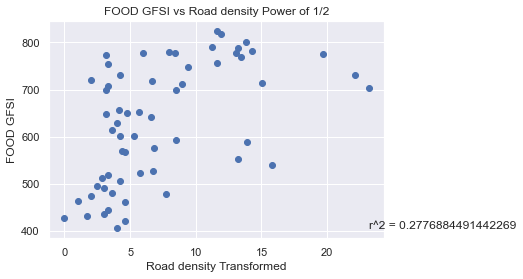

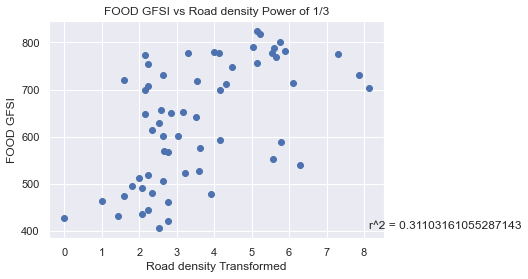

for column = Road density, max_r^2 = 0.31254563402463276, transformation = Natural Log


In [119]:
for column in feature_columns:
    x = df_features_train[column]
    y = df_target_train["FOOD GFSI"]
    max_r = plot_all_transformations(x, y, column, "FOOD GFSI")
    print(f"for column = {column}, max_r^2 = {max_r[0]}, transformation = {max_r[1]}")

### Linearize the Values (If needed)

#### GDP Capita Column

The plot of "FOOD GFSI" column againts "GDP Capita Transformed" empirically shows that the best plot that gives a linear relation is the natural log transformation. The coefficient of correlation also supports that for being the highest as well.

In [120]:
# transform the data with the natural log transformation and add column to df
df_features_train["tf GDP Capita"] = natural_log(df_features_train["GDP Capita"])
df_features_validation["tf GDP Capita"] = natural_log(df_features_validation["GDP Capita"])
df_features_test["tf GDP Capita"] = natural_log(df_features_test["GDP Capita"])

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2130245387.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf GDP Capita"] = natural_log(df_features_train["GDP Capita"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2130245387.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf GDP Capita"] = natural_log(df_features_validation["GDP Capita"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2130245387.py:4: SettingWithCopyWarning: 
A value is trying to be set o

#### Education Index Column

The plot of "FOOD GFSI" column againts "Education Index" empirically shows it is a linear relationship already. However, the correlation coefficient shows that the best one is if we transform the data to the power of 2. 

For this, we decided not to use the power of 2 and stick back with the linear, as the correlation coefficient does not differ as much, and we want to prevent overfitting as well.

In [121]:
# redefine new column with the same values 
df_features_train["tf Education Index"] = df_features_train["Education Index"]
df_features_validation["tf Education Index"] = df_features_validation["Education Index"]
df_features_test["tf Education Index"] = df_features_test["Education Index"]

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/749240118.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Education Index"] = df_features_train["Education Index"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/749240118.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Education Index"] = df_features_validation["Education Index"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/749240118.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

#### Corruption Column

The plot of "FOOD GFSI" column againts "Corruption" empirically shows that the best transformation is the natural log. The correlation coefficient supports this as well by having the maximum values as compared to the other transformations.

In [122]:
# add new column with natural log transformation for corruption
df_features_train["tf Corruption"] = natural_log(df_features_train["Corruption"])
df_features_validation["tf Corruption"] = natural_log(df_features_validation["Corruption"])
df_features_test["tf Corruption"] = natural_log(df_features_test["Corruption"])

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2436263829.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Corruption"] = natural_log(df_features_train["Corruption"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2436263829.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Corruption"] = natural_log(df_features_validation["Corruption"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2436263829.py:4: SettingWithCopyWarning: 
A value is trying to be set o

#### Vaccination Rate (%) Column

The plot of "FOOD GFSI" against "Vaccination Rate (%)" shows the best transformation is no transformation at all. The correlation coefficient also supports this.

In [123]:
# redefine new column
df_features_train["tf Vaccination Rate (%)"] = df_features_train["Vaccination Rate (%)"]
df_features_validation["tf Vaccination Rate (%)"] = df_features_validation["Vaccination Rate (%)"]
df_features_test["tf Vaccination Rate (%)"] = df_features_test["Vaccination Rate (%)"]

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/818210681.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Vaccination Rate (%)"] = df_features_train["Vaccination Rate (%)"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/818210681.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Vaccination Rate (%)"] = df_features_validation["Vaccination Rate (%)"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/818210681.py:4: SettingWithCopyWarning: 
A value is trying 

#### Political Stability Column

The plot of "FOOD GFSI" against "Political Stability" shows the best transformation is no transformation at all. The correlation coefficient also supports this.

In [124]:
# redefine new column
df_features_train["tf Political Stability"] = df_features_train["Political Stability"]
df_features_validation["tf Political Stability"] = df_features_validation["Political Stability"]
df_features_test["tf Political Stability"] = df_features_test["Political Stability"]
display(df.head())

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2889821947.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Political Stability"] = df_features_train["Political Stability"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2889821947.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Political Stability"] = df_features_validation["Political Stability"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2889821947.py:4: SettingWithCopyWarning: 
A value is trying t

,Country,FOOD GFSI,GDP Capita,Education Index,Corruption,Vaccination Rate (%),Political Stability,Crop Production,Percentage of Export,Poverty Rate,Road density
0,Finland,825,49964.50,0.905,89.0,78.42,98.0,106.4,16.852496,12.2,135.0
1,Ireland,817,79068.97,0.918,73.0,80.72,86.0,88.1,46.479800,13.1,142.0
3,France,802,41572.49,0.840,69.0,78.30,37.0,98.9,42.414468,13.6,191.0
5,Japan,795,39808.17,0.848,72.0,83.07,103.0,96.4,1.259819,15.7,93.0
6,Sweden,791,54589.06,0.904,88.0,72.31,103.0,105.2,27.315509,17.1,127.0


#### Crop Production

The plot of "FOOD GFSI" against "Crop Production" shows the best transformation is natural log transformation by its correlation coefficient. However, as we want to prevent overfitting, we choose the no transformation.

In [125]:
# redefine new column
df_features_train["tf Crop Production"] = df_features_train["Crop Production"]
df_features_validation["tf Crop Production"] = df_features_validation["Crop Production"]
df_features_test["tf Crop Production"] = df_features_test["Crop Production"]

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/1847542806.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Crop Production"] = df_features_train["Crop Production"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/1847542806.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Crop Production"] = df_features_validation["Crop Production"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/1847542806.py:4: SettingWithCopyWarning: 
A value is trying to be set on a co

#### Percentage of Export

The plot of "FOOD GFSI" against "Percentage of Export" shows the best transformation is natural log transformation by its correlation coefficient.

In [126]:
# redefine new column
df_features_train["tf Percentage of Export"] = natural_log(df_features_train["Percentage of Export"])
df_features_validation["tf Percentage of Export"] = natural_log(df_features_validation["Percentage of Export"])
df_features_test["tf Percentage of Export"] = natural_log(df_features_test["Percentage of Export"])

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2251544980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Percentage of Export"] = natural_log(df_features_train["Percentage of Export"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2251544980.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Percentage of Export"] = natural_log(df_features_validation["Percentage of Export"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/2251544980.py:4: SettingWithCop

#### Poverty Rate

The plot of "FOOD GFSI" against "Poverty Rate" shows the best transformation is no transformation at all. The correlation coefficient also supports that.

In [127]:
# redefine new column
df_features_train["tf Poverty Rate"] = df_features_train["Poverty Rate"]
df_features_validation["tf Poverty Rate"] = df_features_validation["Poverty Rate"]
df_features_test["tf Poverty Rate"] = df_features_test["Poverty Rate"]

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/242759797.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Poverty Rate"] = df_features_train["Poverty Rate"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/242759797.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Poverty Rate"] = df_features_validation["Poverty Rate"]
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/242759797.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice f

#### Road density

The plot of "FOOD GFSI" against "Road density" shows the best transformation is natural log transfomration. The correlation coefficient also supports that.

In [128]:
# redefine new column
df_features_train["tf Road density"] = natural_log(df_features_train["Road density"])
df_features_validation["tf Road density"] = natural_log(df_features_validation["Road density"])
df_features_test["tf Road density"] = natural_log(df_features_test["Road density"])

C:\Users\AW\AppData\Local\Temp/ipykernel_14840/4112766192.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_train["tf Road density"] = natural_log(df_features_train["Road density"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/4112766192.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_features_validation["tf Road density"] = natural_log(df_features_validation["Road density"])
C:\Users\AW\AppData\Local\Temp/ipykernel_14840/4112766192.py:4: SettingWithCopyWarning: 
A value is trying to 

In [129]:
print(df_features_train["tf Road density"].to_string())

0      4.905349
1      4.955897
3      5.252326
6      4.844266
8      5.164843
10     5.318169
12     4.159039
13     5.141722
14     3.583797
15     4.262821
16     5.961031
17     2.303585
18     5.193012
19     4.905349
21     2.398804
23     4.488749
27     6.192383
28     2.890927
31     1.388791
32     3.784417
33     5.424994
35     4.382152
36     2.398804
37     6.286017
40     2.303585
41     4.276805
47     2.833801
49     3.466048
50     3.135929
53     2.303585
55     3.761433
57     2.773214
59     2.565718
62     3.332562
64     2.890927
66     4.276805
68     5.267910
72     3.850360
73     2.944965
74     3.044999
78     5.159113
79     5.521501
82     3.828859
83     3.496811
84     2.398804
85     2.080691
87     2.890927
88     1.793425
89     2.198335
91     2.565718
92     4.094511
93     1.388791
96     0.009950
97     3.044999
99     2.398804
101    2.198335
102    1.101940
104   -4.605170
106    3.044999
109    2.773214


#### Re-Plot Everything to Reconfirm Linear Relationship

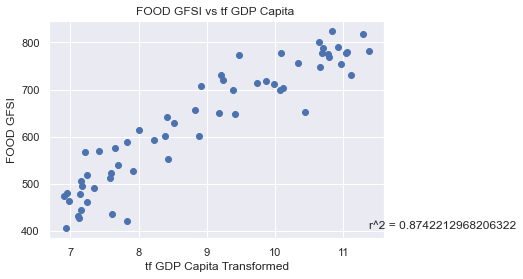

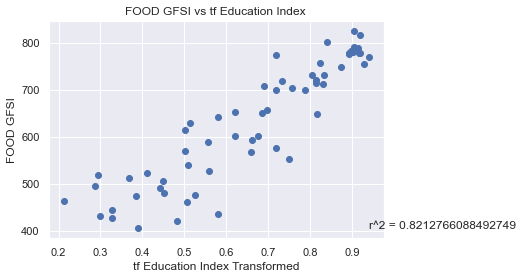

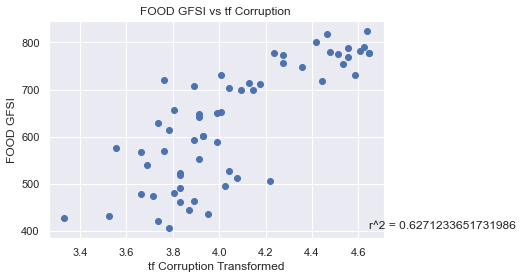

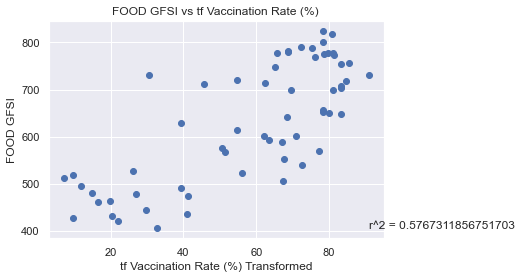

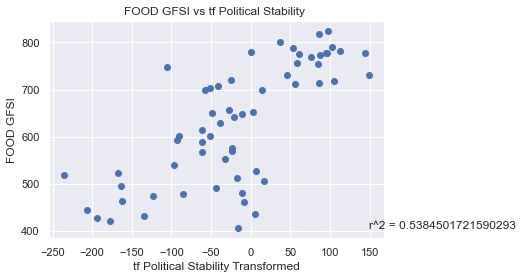

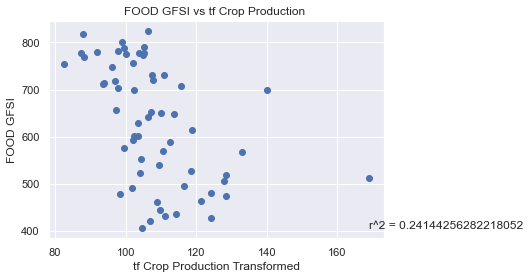

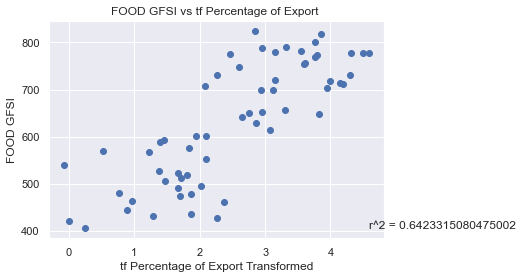

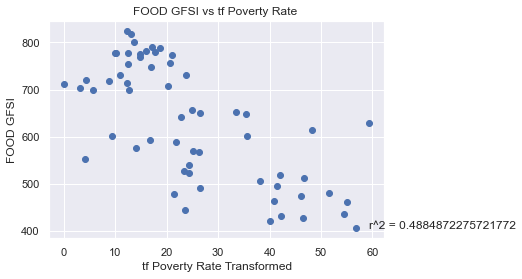

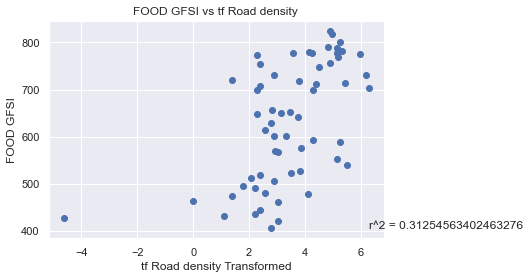

In [130]:
for column in df_features_train.columns:
    if "tf" in column:
        plot_scatter(df_features_train[column], df_target_train["FOOD GFSI"], column, "FOOD GFSI", "")

In [131]:
# checking for NaN values just in case, internal testing
df_features_train.isna().sum()

GDP Capita                 0
Education Index            0
Corruption                 0
Vaccination Rate (%)       0
Political Stability        0
Crop Production            0
Percentage of Export       0
Poverty Rate               0
Road density               0
tf GDP Capita              0
tf Education Index         0
tf Corruption              0
tf Vaccination Rate (%)    0
tf Political Stability     0
tf Crop Production         0
tf Percentage of Export    0
tf Poverty Rate            0
tf Road density            0
dtype: int64

In [132]:
# check shape
df_features_train.shape

(60, 18)

## DO ML

For practicality, we define a new list that contains all the transformed columns.

In [133]:
feature_columns_tf = [column for column in df_features_test.columns if "tf" in column]
print(feature_columns_tf)

target_column = ["FOOD GFSI"]

['tf GDP Capita', 'tf Education Index', 'tf Corruption', 'tf Vaccination Rate (%)', 'tf Political Stability', 'tf Crop Production', 'tf Percentage of Export', 'tf Poverty Rate', 'tf Road density']


In [134]:
# convert df to tf-ed version
df_features_train_tf = df_features_train[feature_columns_tf]
df_features_validation_tf = df_features_validation[feature_columns_tf]
df_features_test_tf = df_features_test[feature_columns_tf]

# Normalize the features using z normalization
df_features_train_tf_z = normalize_z(df_features_train_tf)

# Change the features and the target to numpy array using the prepare functions
X = prepare_feature(df_features_train_tf_z)
#print(X)
target = prepare_target(df_target_train)


iterations = 1500
alpha = 0.01
beta2 = np.zeros((df_features_train_tf_z.shape[1] + 1,1))


# Call the gradient_descent function
beta2, J_storage = gradient_descent(X, target, beta2, alpha, iterations)
 
# call the predict() method
pred = predict(df_features_validation_tf, beta2)

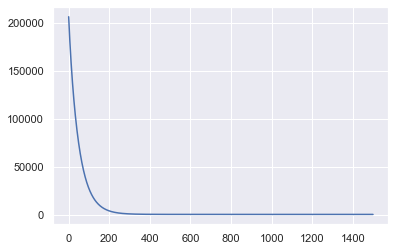

In [135]:
plt.plot(J_storage)

tf GDP Capita


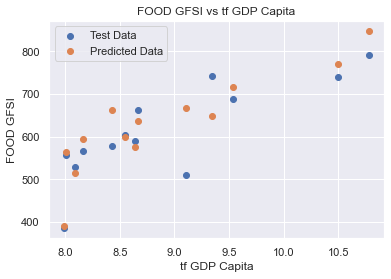

tf Education Index


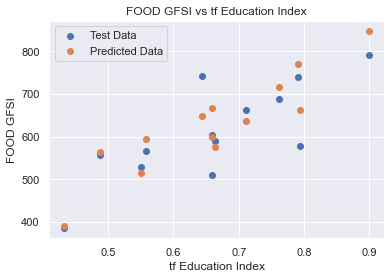

tf Corruption


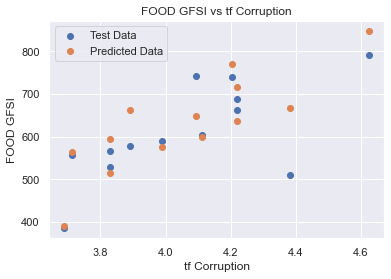

tf Vaccination Rate (%)


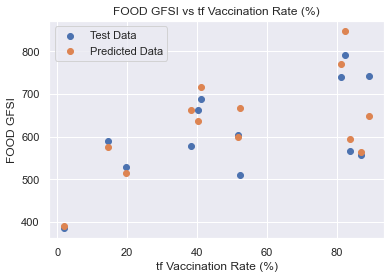

tf Political Stability


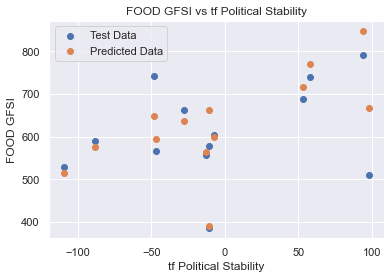

tf Crop Production


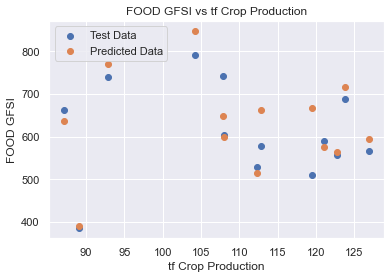

tf Percentage of Export


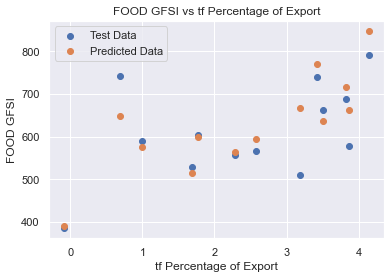

tf Poverty Rate


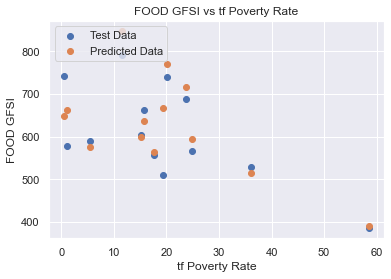

tf Road density


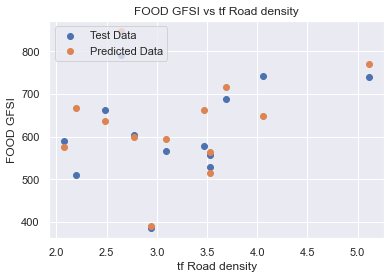

In [136]:
for column in feature_columns_tf:
    print(column)
    x = df_features_validation_tf[column]
    y_test = df_target_validation["FOOD GFSI"]
    y_pred = pred
    plt.scatter(x, y_test, label="Test Data")
    plt.scatter(x, y_pred, label="Predicted Data")
    plt.xlabel(f"{column}")
    plt.ylabel("FOOD GFSI")
    plt.title(f"FOOD GFSI vs {column}")
    plt.legend(loc="upper left")
    plt.show()

In [137]:
target = prepare_target(df_target_validation)
r2 = r2_score(target, pred)
print(f"r^2 = {r2[0]}")

target = prepare_target(df_target_validation)
adj_r2 = adj_r2_score(target, pred, df_features_validation_tf.shape[0], df_features_validation_tf.shape[1])
print(f"adj r^2 = {adj_r2[0]}")

target = prepare_target(df_target_validation)
mse = mean_squared_error(target, pred)
print(f"mse = {mse[0]}")

target = prepare_target(df_target_validation)
mae = mean_absolute_error(target, pred)
print(f"mae = {mae[0]}")

r^2 = 0.6806662864281274
adj r^2 = -0.2773348542874903
mse = 3657.1570726159634
mae = 42.36880987059453


Adjusted r-squared is smaller than before, but it is still negative. That means the model got more accurate, but is still prone to hyperparameterization.
<br>
<br>
Hence, in the next iteration, we will be eliminating irrelevant features.

In [138]:
print(beta2)

[[630.04982128]
 [ 45.74025239]
 [ 27.40046009]
 [ 11.48862154]
 [ 19.38513335]
 [ -3.23186284]
 [  9.20111024]
 [ 30.03523432]
 [-10.47576848]
 [  1.7076067 ]]


# Third Iteration: Backwards Elimination

To improve our model, we must be selective about the selected features. Thus, we use backward elimination algorithm to iterate through the elimination of certain model features. In each iteration, we compute the respective p value of all features and remove the highest one. p value representing the feature's statistical significance to the target (GFSI). If the resultant standard decreases, we repeat this process until we can no longer decrease the standard error value.


In [139]:
from scipy import stats

# standard error
se_all = []
beta_all = []

# put dataframes to other variabels
df_features_train_tf_3 = df_features_train_tf[df_features_train_tf.columns]
# display(df_features_train_tf_3, df_target_train)
df_features_test_tf_3 = df_features_test_tf[df_features_test_tf.columns]
df_features_validation_tf_3 = df_features_validation_tf[df_features_validation_tf.columns]

for i in range(df_features.shape[1]):
    print(f"Iteration {i+1} ____________________")
    # Normalize the features using z normalization
    df_features_train_tf_z = normalize_z(df_features_train_tf_3)
    display(df_features_train_tf_z.head(2))
    
    X = prepare_feature(df_features_train_tf_z)
    target = prepare_target(df_target_train)

    iterations = 1500
    alpha = 0.01
    beta3 = np.zeros((df_features_train_tf_z.shape[1] + 1,1))

    # Call the gradient_descent function, append beta
    beta3, J_storage = gradient_descent(X, target, beta3, alpha, iterations)
    beta_all.append(beta3)
    
    # call the predict() method, with validation
    pred = predict(df_features_validation_tf_3, beta3)

    # check metrics
    target = prepare_target(df_target_validation)
    r2 = r2_score(target, pred)
    print(f"r^2 = {r2[0]}")

    target = prepare_target(df_target_validation)
    adj_r2 = adj_r2_score(target, pred, df_features_train_tf_z.shape[0], df_features_train_tf_z.shape[1])
    print(f"adj r^2 = {adj_r2[0]}")

    target = prepare_target(df_target_validation)
    mse = mean_squared_error(target, pred)
    print(f"mse = {mse[0]}")

    target = prepare_target(df_target_validation)
    mae = mean_absolute_error(target, pred)
    print(f"mae = {mae[0]}")

    se = stats.sem(pred)[0]
    # print(f"se = {se}")

    if i > 0:
        if se > se_all[len(se_all) - 1]:
            # re-add previously dropped column
            # df_features_train_tf_3[column_big_p] = df_features_train_tf[column_big_p] 
            # df_features_test_tf_3[column_big_p] = df_features_test_tf[column_big_p]
            # df_features_validation_tf_3[column_big_p] = df_features_validation_tf[column_big_p]
            # # pop the last beta index, coz we want the one before that
            # beta_all.pop()
            break
    se_all.append(se)

    # test p-value with validation
    p_vals_dict = {}

    for column in df_features_validation_tf_3.columns:
        p_vals_dict[column] = stats.pearsonr(df_features_validation_tf_3[column], pred)[1]
    print(p_vals_dict) 
    column_big_p = max(p_vals_dict, key = lambda k: p_vals_dict[k])

    df_features_train_tf_3 = df_features_train_tf_3.drop(columns=[column_big_p])
    df_features_test_tf_3 = df_features_test_tf_3.drop(columns=[column_big_p])
    df_features_validation_tf_3 = df_features_validation_tf_3.drop(columns=[column_big_p])

beta3 = beta_all[len(beta_all) - 1]
# print(se_all)
print(beta3)

Iteration 1 ____________________


,tf GDP Capita,tf Education Index,tf Corruption,tf Vaccination Rate (%),tf Political Stability,tf Crop Production,tf Percentage of Export,tf Poverty Rate,tf Road density
0,1.288892,1.204860,1.740201,0.843085,1.265701,-0.112396,0.286832,-0.831501,0.849321
1,1.595300,1.267651,1.230285,0.936706,1.134917,-1.418325,1.123741,-0.772513,0.878487


r^2 = 0.6806662864281274
adj r^2 = 0.6231862179851904
mse = 3657.1570726159634
mae = 42.36880987059453
{'tf GDP Capita': 6.40016050432127e-05, 'tf Education Index': 1.4332168820938807e-05, 'tf Corruption': 0.0003618957123059838, 'tf Vaccination Rate (%)': 0.034840823057891705, 'tf Political Stability': 0.014491485775119717, 'tf Crop Production': 0.9258905434016088, 'tf Percentage of Export': 0.00134603490405463, 'tf Poverty Rate': 0.030184708310396203, 'tf Road density': 0.4709873327913611}
Iteration 2 ____________________


,tf GDP Capita,tf Education Index,tf Corruption,tf Vaccination Rate (%),tf Political Stability,tf Percentage of Export,tf Poverty Rate,tf Road density
0,1.288892,1.204860,1.740201,0.843085,1.265701,0.286832,-0.831501,0.849321
1,1.595300,1.267651,1.230285,0.936706,1.134917,1.123741,-0.772513,0.878487


r^2 = 0.6927470774962061
adj r^2 = 0.644550540632866
mse = 3518.8022775546033
mae = 40.39687067649029
{'tf GDP Capita': 2.521477999982467e-05, 'tf Education Index': 8.417901561441847e-06, 'tf Corruption': 0.0001495458812225205, 'tf Vaccination Rate (%)': 0.044650782764660335, 'tf Political Stability': 0.011221520184118608, 'tf Percentage of Export': 0.001628033933712184, 'tf Poverty Rate': 0.04136652271502007, 'tf Road density': 0.5002006850606199}
Iteration 3 ____________________


,tf GDP Capita,tf Education Index,tf Corruption,tf Vaccination Rate (%),tf Political Stability,tf Percentage of Export,tf Poverty Rate
0,1.288892,1.204860,1.740201,0.843085,1.265701,0.286832,-0.831501
1,1.595300,1.267651,1.230285,0.936706,1.134917,1.123741,-0.772513


r^2 = 0.6945181609439794
adj r^2 = 0.6533956056864383
mse = 3498.5190124875735
mae = 40.476860496898844
{'tf GDP Capita': 2.4837031913294496e-05, 'tf Education Index': 8.672281773056037e-06, 'tf Corruption': 0.0001642018079391715, 'tf Vaccination Rate (%)': 0.044085291407698346, 'tf Political Stability': 0.011304000984796312, 'tf Percentage of Export': 0.0015942375348951014, 'tf Poverty Rate': 0.04213159446983736}
Iteration 4 ____________________


,tf GDP Capita,tf Education Index,tf Corruption,tf Political Stability,tf Percentage of Export,tf Poverty Rate
0,1.288892,1.204860,1.740201,1.265701,0.286832,-0.831501
1,1.595300,1.267651,1.230285,1.134917,1.123741,-0.772513


r^2 = 0.640228584492517
adj r^2 = 0.5994997450011038
mse = 4120.268298737315
mae = 45.987877181854365
[[ 6.30049821e+02]
 [ 5.18041104e+01]
 [ 3.09962460e+01]
 [ 1.11369656e+01]
 [ 2.59623359e-01]
 [ 2.53793729e+01]
 [-1.36826393e+01]]


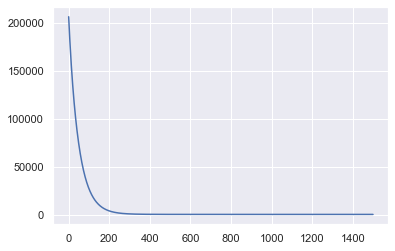

In [140]:
plt.plot(J_storage)

tf GDP Capita


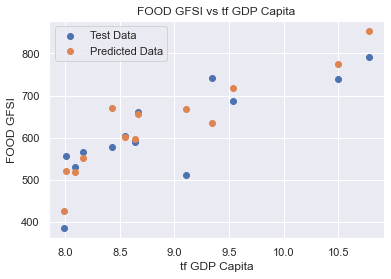

tf Education Index


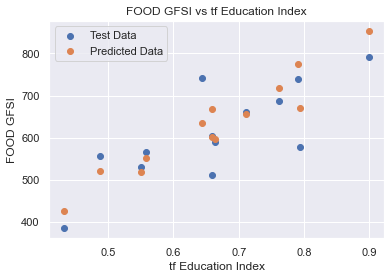

tf Corruption


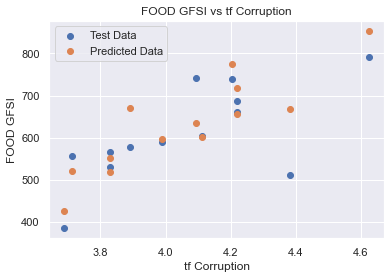

tf Vaccination Rate (%)


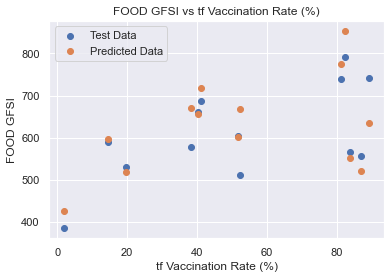

tf Political Stability


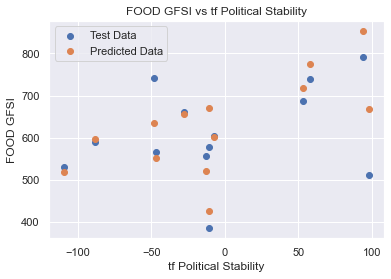

tf Crop Production


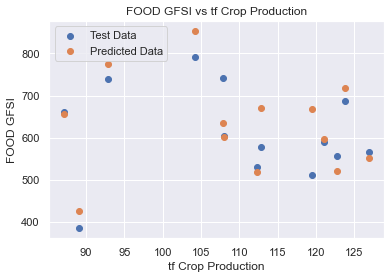

tf Percentage of Export


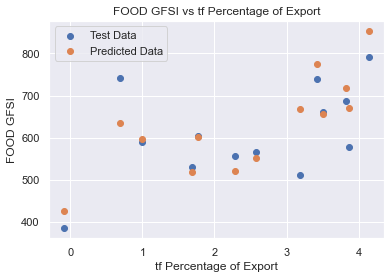

tf Poverty Rate


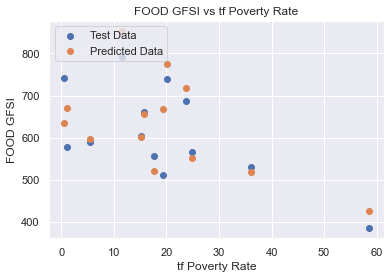

tf Road density


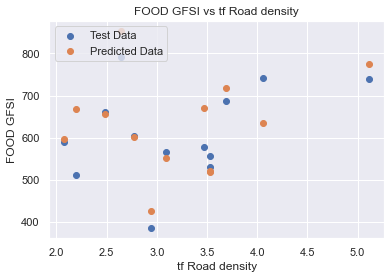

In [141]:
for column in df_features_validation_tf.columns:
    print(column)
    x = df_features_validation_tf[column]
    y_test = df_target_validation["FOOD GFSI"]
    y_pred = pred
    plt.scatter(x, y_test, label="Test Data")
    plt.scatter(x, y_pred, label="Predicted Data")
    plt.xlabel(f"{column}")
    plt.ylabel("FOOD GFSI")
    plt.title(f"FOOD GFSI vs {column}")
    plt.legend(loc="upper left")
    plt.show()

In [142]:
# check metrics
pred = predict(df_features_validation_tf_3, beta3)

target = prepare_target(df_target_validation)
r2 = r2_score(target, pred)
print(f"r^2 = {r2[0]}")

target = prepare_target(df_target_validation)
adj_r2 = adj_r2_score(target, pred, df_features_validation_tf_3.shape[0], df_features_validation_tf_3.shape[1])
print(f"adj r^2 = {adj_r2[0]}")

target = prepare_target(df_target_validation)
mse = mean_squared_error(target, pred)
print(f"mse = {mse[0]}")

target = prepare_target(df_target_validation)
mae = mean_absolute_error(target, pred)
print(f"mae = {mae[0]}")

r^2 = 0.640228584492517
adj r^2 = 0.2804571689850338
mse = 4120.268298737315
mae = 45.987877181854365


# Final Testing

In [143]:
# check metrics
pred = predict(df_features_test_tf_3, beta3)

target = prepare_target(df_target_test)
r2 = r2_score(target, pred)
print(f"r^2 = {r2[0]}")

target = prepare_target(df_target_test)
adj_r2 = adj_r2_score(target, pred, df_features_test_tf_3.shape[0], df_features_test_tf_3.shape[1])
print(f"adj r^2 = {adj_r2[0]}")

target = prepare_target(df_target_test)
mse = mean_squared_error(target, pred)
print(f"mse = {mse[0]}")

target = prepare_target(df_target_test)
mae = mean_absolute_error(target, pred)
print(f"mae = {mae[0]}")

r^2 = 0.9098568609151075
adj r^2 = 0.8016850940132365
mse = 1651.32966092006
mae = 33.666983108300094


As can be seen, those are good values given that the GFSI range falls between 400 and 800.

tf GDP Capita


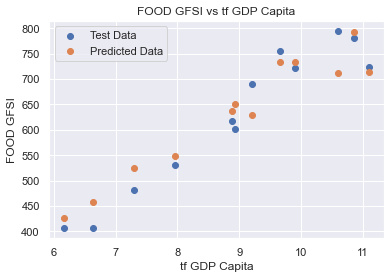

tf Education Index


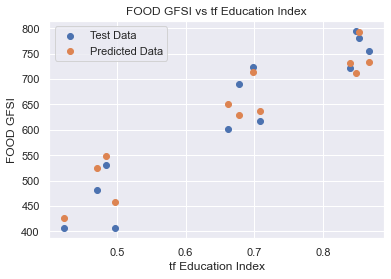

tf Corruption


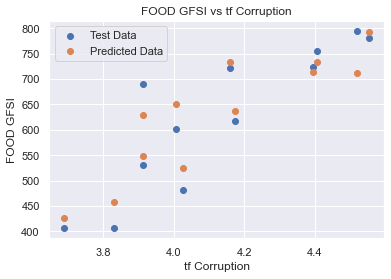

tf Vaccination Rate (%)


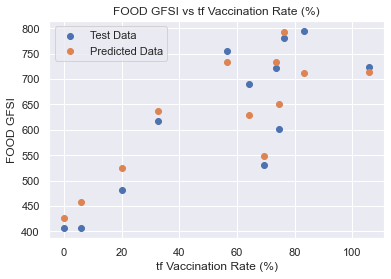

tf Political Stability


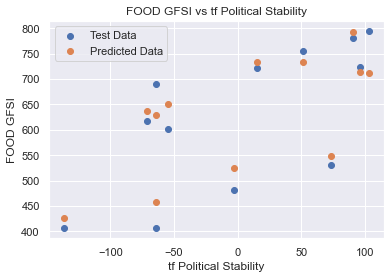

tf Crop Production


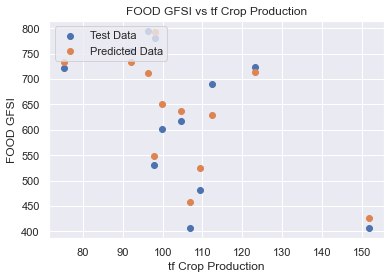

tf Percentage of Export


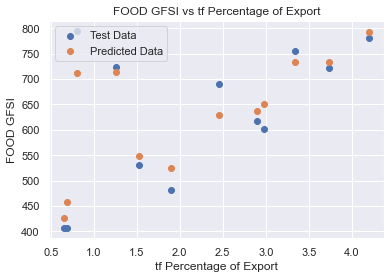

tf Poverty Rate


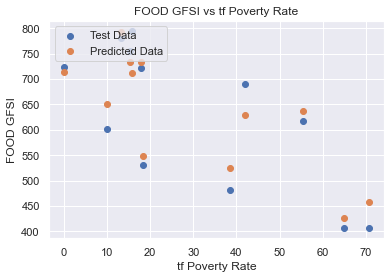

tf Road density


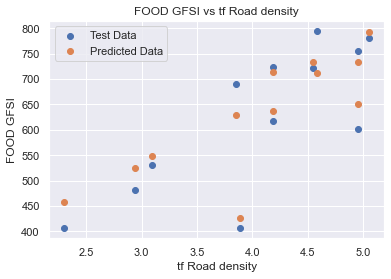

In [144]:
for column in df_features_test_tf.columns:
    print(column)
    x = df_features_test_tf[column]
    y_test = df_target_test["FOOD GFSI"]
    y_pred = pred
    plt.scatter(x, y_test, label="Test Data")
    plt.scatter(x, pred, label="Predicted Data")
    plt.xlabel(f"{column}")
    plt.ylabel("FOOD GFSI")
    plt.title(f"FOOD GFSI vs {column}")
    plt.legend(loc="upper left")
    plt.show()